In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glmnet_python
import glmnet as gln


from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error


%matplotlib inline
plt.style.use('seaborn-white')

In [49]:
df = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [50]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [51]:
y = df.Salary
x_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
x = pd.concat([x_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [52]:
x.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [53]:
x_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
x_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

## Ridge Regression

In [54]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas




array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [55]:
ridge = Ridge(normalize=True)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(x, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 19)

Text(0, 0.5, 'weights')

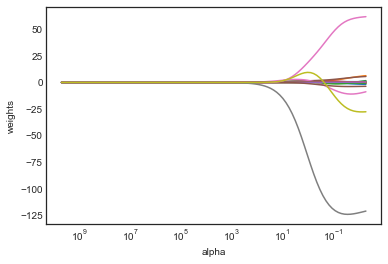

In [61]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [63]:
from sklearn.model_selection import train_test_split
x_train, x_test , y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1)


In [66]:
ridge2 = Ridge(alpha=4, normalize=True)
ridge2.fit(x_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(x_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=x.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))        # Calculate the test MSE

AtBat           0.098658
Hits            0.446094
HmRun           1.412107
Runs            0.660773
RBI             0.843403
Walks           1.008473
Years           2.779882
CAtBat          0.008244
CHits           0.034149
CHmRun          0.268634
CRuns           0.070407
CRBI            0.070060
CWalks          0.082795
PutOuts         0.104747
Assists        -0.003739
Errors          0.268363
League_N        4.241051
Division_W    -30.768885
NewLeague_N     4.123474
dtype: float64
106216.52238005561


In [68]:
ridge3 = Ridge(alpha=10**10, normalize=True)
ridge3.fit(x_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(x_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index=x.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))        # Calculate the test MSE

AtBat          1.317464e-10
Hits           4.647486e-10
HmRun          2.079865e-09
Runs           7.726175e-10
RBI            9.390640e-10
Walks          9.769219e-10
Years          3.961442e-09
CAtBat         1.060533e-11
CHits          3.993605e-11
CHmRun         2.959428e-10
CRuns          8.245247e-11
CRBI           7.795451e-11
CWalks         9.894387e-11
PutOuts        7.268991e-11
Assists       -2.615885e-12
Errors         2.084514e-10
League_N      -2.501281e-09
Division_W    -1.549951e-08
NewLeague_N   -2.023196e-09
dtype: float64
172862.23580379886


In [74]:
ridge2 = Ridge(alpha=0, normalize=True)
ridge2.fit(x_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(x_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=x.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))         # Calculate the test MSE

AtBat           -1.821115
Hits             4.259156
HmRun           -4.773401
Runs            -0.038760
RBI              3.984578
Walks            3.470126
Years            9.498236
CAtBat          -0.605129
CHits            2.174979
CHmRun           2.979306
CRuns            0.266356
CRBI            -0.598456
CWalks           0.171383
PutOuts          0.421063
Assists          0.464379
Errors          -6.024576
League_N       133.743163
Division_W    -113.743875
NewLeague_N    -81.927763
dtype: float64
116690.46856660453


In [77]:
from sklearn.metrics import mean_squared_error

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', normalize=True)
ridgecv.fit(x_train, y_train)
ridgecv.alpha_

0.5748784976988678

In [78]:
ridge4 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge4.fit(x_train, y_train)
mean_squared_error(y_test, ridge4.predict(x_test))

99825.6489629273

In [79]:
ridge4.fit(x, y)
pd.Series(ridge4.coef_, index=x.columns)

AtBat           0.055838
Hits            0.934879
HmRun           0.369048
Runs            1.092480
RBI             0.878259
Walks           1.717770
Years           0.783515
CAtBat          0.011318
CHits           0.061101
CHmRun          0.428333
CRuns           0.121418
CRBI            0.129351
CWalks          0.041990
PutOuts         0.179957
Assists         0.035737
Errors         -1.597699
League_N       24.774519
Division_W    -85.948661
NewLeague_N     8.336918
dtype: float64

NameError: name 'X_train' is not defined

In [28]:
grid = 10**np.linspace(10,-2,100)

from sklearn.linear_model import ElasticNet
ridge3 = ElasticNet(alpha=0, l1_ratio=1)
ridge3.fit(x, y)



C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """
C:\Users\galen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\galen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
ridge3.lambda_path_[49]

AttributeError: 'ElasticNet' object has no attribute 'lambda_path_'